In [1]:
import rdkit

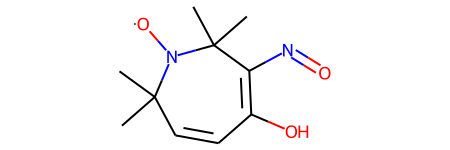

In [2]:
mol = rdkit.Chem.MolFromSmiles('CC1(C)C=CC(O)=C(N=O)C(C)(C)N1[O]')
mol

In [3]:
model_dir = "/projects/rlmolecule/pstjohn/models/"; 
stability_model = f"{model_dir}/20210214_radical_stability_new_data/"
redox_model = f"{model_dir}/20210214_redox_new_data/"
bde_model = f"{model_dir}/20210216_bde_new_nfp/"

from stable_radical_opt_from_initial_center import construct_problem
from rlmolecule.molecule.molecule_state import MoleculeState

In [4]:
problem = construct_problem(stability_model=stability_model, redox_model=redox_model, bde_model=bde_model)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [5]:
import pandas as pd

In [6]:
def calc_reward(smiles):
    
    reward, data = problem.calc_reward(MoleculeState(
        rdkit.Chem.MolFromSmiles(smiles), None))

    data = pd.Series(data)
    data['reward'] = reward
    data['SMILES'] = smiles
    return data

df = pd.DataFrame([calc_reward(smiles) for smiles in ['CC1(C)C=CC(O)=C(N=O)C(C)(C)N1[O]',
                                                 'CC1(C)C=CC=C(N=O)C(C)(C)N1[O]',
                                                 'CC1(C)C=CC(O)=CC(C)(C)N1[O]',
                                                 'CC1(C)C=CC=CC(C)(C)N1[O]']])

In [7]:
df.set_index('SMILES').astype(float).round(3)

,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff,reward
SMILES,,,,,,,
CC1(C)C=CC(O)=C(N=O)C(C)(C)N1[O],0.228,65.260,0.988,-0.249,73.389,6.253,203.860
CC1(C)C=CC=C(N=O)C(C)(C)N1[O],0.283,46.325,0.986,-0.505,73.371,27.327,169.163
CC1(C)C=CC(O)=CC(C)(C)N1[O],0.384,65.701,0.833,-0.770,73.188,8.784,169.344
CC1(C)C=CC=CC(C)(C)N1[O],0.384,45.931,0.809,-0.791,73.183,27.752,149.914


In [8]:
import tensorflow as tf
import numpy as np

@tf.function(experimental_relax_shapes=True)
def predict(model: 'tf.keras.Model', inputs):
    return model.predict_step(inputs)

def pred_spins(mol):
    spins, _ = predict(problem.stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in problem.get_policy_inputs(MoleculeState(mol, None)).items()})
    
    return spins.numpy().flatten()

In [9]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG, Image

array([0.01605808, 0.02725838, 0.01605808, 0.05479348, 0.02876287,
       0.05498691, 0.01044445, 0.02767207, 0.07806558, 0.15320879,
       0.06052802, 0.01926884, 0.01926884, 0.22799507, 0.20563056],
      dtype=float32)

N


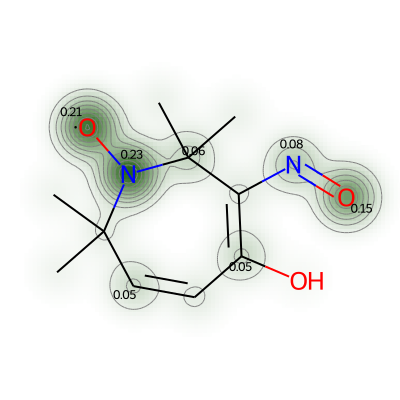

In [19]:
mol = Chem.MolFromSmiles('CC1(C)C=CC(O)=C(N=O)C(C)(C)N1[O]')
print(np.array([a.GetSymbol() for a in mol.GetAtoms()][pred_spins(mol).argmax()]))

for atom, spin in zip(mol.GetAtoms(), pred_spins(mol)):
    if spin > 0.05:
        mol.GetAtomWithIdx(atom.GetIdx()).SetProp("atomNote",f"{spin:.2f}")

d = rdMolDraw2D.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

O


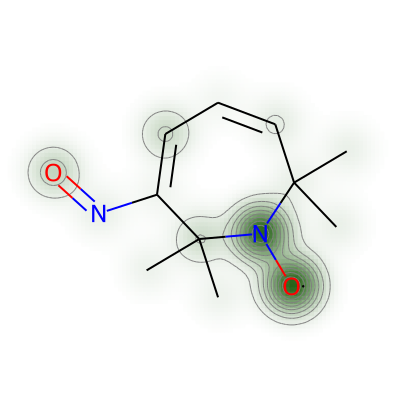

In [11]:
mol = Chem.MolFromSmiles('CC1(C)C=CC=C(N=O)C(C)(C)N1[O]')
print(np.array([a.GetSymbol() for a in mol.GetAtoms()][pred_spins(mol).argmax()]))

d = rdMolDraw2D.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

In [ ]:
mol = Chem.MolFromSmiles('CC1(C)C=CC(O)=CC(C)(C)N1[O]')
print(np.array([a.GetSymbol() for a in mol.GetAtoms()][pred_spins(mol).argmax()]))

d = rdMolDraw2D.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

In [ ]:
mol = Chem.MolFromSmiles('CC1=C(N)C2=C(S[NH])CCCC2=CC1=O')
print(np.array([a.GetSymbol() for a in mol.GetAtoms()][pred_spins(mol).argmax()]))

d = rdMolDraw2D.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

In [ ]:
mol = Chem.MolFromSmiles('CC1=C2CCC(C)(C)N([NH])C2=C(C)C1=O')
print(np.array([a.GetSymbol() for a in mol.GetAtoms()][pred_spins(mol).argmax()]))

d = rdMolDraw2D.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

In [ ]:
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
import sqlalchemy

# connect to the db
dbname = "bde"
port = "5432"
host = "yuma.hpc.nrel.gov"
user = "rlops"
# read the password from a file
passwd_file = '/projects/rlmolecule/rlops_pass'
with open(passwd_file, 'r') as f:
    passwd = f.read().strip()

drivername = "postgresql+psycopg2"
engine_str = f'{drivername}://{user}:{passwd}@{host}:{port}/{dbname}'
engine = sqlalchemy.create_engine(engine_str, execution_options={"isolation_level": "AUTOCOMMIT"})

Session.configure(bind=engine)
session = Session()

In [ ]:
run_id = 'stable_radical_optimization_psj_NO_l'

df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).filter(
    RewardStore.reward > 150).order_by(
    RewardStore.reward.desc()).statement, session.bind)

df_rewards['smiles'] = df_rewards.data.apply(lambda x: x['smiles'])

In [ ]:
df_rewards.shape

In [ ]:
smarts = rdkit.Chem.MolFromSmarts('C(-[CH3])(-[CH3])-[NR1](-[OX1])-C(-[CH3])(-[CH3])')
mol = Chem.MolFromSmiles('CC1(C)C=CC=C(N=O)C(C)(C)N1[O]')
mol.HasSubstructMatch(smarts)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
has_match = df_rewards.smiles.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(smarts))

In [ ]:
sum(has_match)

In [ ]:
mols

In [ ]:
opts = d2d.drawOptions()

In [ ]:
to_plot = df_rewards[has_match].copy()
to_plot['num_atoms'] = to_plot.smiles.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
to_plot = to_plot.sort_values(by=['num_atoms', 'reward'], ascending=[True, False])

In [ ]:
to_plot = to_plot.groupby('num_atoms').apply(lambda x: x.iloc[:2]).reset_index(drop=True)

In [ ]:
mols = list(to_plot.head(20).smiles.apply(rdkit.Chem.MolFromSmiles))
d2d = rdMolDraw2D.MolDraw2DCairo(200*3,200*5,200,200)
d2d.drawOptions().fixedBondLength=5
d2d.drawOptions().addStereoAnnotation=True
d2d.DrawMolecules(mols, legends=[f'num_atoms={row.num_atoms}\nreward={row.reward:.1f}' for _, row in to_plot.head(20).iterrows()])
d2d.FinishDrawing()
Image(d2d.GetDrawingText())

In [ ]:
mol

In [ ]:
df_rewards.smiles